[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)'

## **CAP-730 Aprendizado Profundo (*Deep Leraning*)**
### **Otimizando redes neurais convolucionais para detecção de pistas de pouso no bioma amazônico usando imagens**

**Docentes:** *Dr. Valdivino Alexandre de Santiago Junior, Dr. Elcio Hideiti Shiguemori e Dr. Thales Sehn Körti*

**Discente:** *Lourenço José Cavalcante Neto*

---



### Objetivo:

Nesta atividade, vamos explorar o problema de detecção de pistas de pouso no bioma amazônico utilizando redes neurais convolucionais. O principal objetivo desta atividade foi familiarizar-se com os conceitos básicos de redes neurais profundas, enquanto realizamos uma tarefa prática de classificação usando imagens, aplicando técnicas de aprendizado profundo.

### Importação das bibliotecas necessárias

In [1]:
from datetime import datetime

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image  # Ajuste para o import correto
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


#from keras.preprocessing import image
import matplotlib.pyplot as plt

import random  # Para embaralhar as imagens

# Configuração para exibir gráficos
%matplotlib inline

2024-10-31 03:03:03.110532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Carregar imagens de treinamento e teste  
O primeiro passo é carregar as imagens que serão usadas para treinamento e teste, rotulando-as com 0 para “NaoPista” e 1 para “Pista”. Vamos começar definindo uma função para carregar as imagens do sistema de arquivos e atribuir os rótulos a elas, além de outra função para exibir as imagens. Também definiremos quatro listas em Python para armazenar as imagens usadas no treinamento e teste (`x_train` e `x_test`) e os rótulos correspondentes (`y_train` e `y_test`).

In [2]:
# Caminhos para os diretórios de imagens
train_pista_path = './Treinamento/Pistas'       # Caminho para a pasta de imagens "Pistas" no treinamento
train_naopista_path = './Treinamento/NaoPistas' # Caminho para a pasta de imagens "NaoPistas" no treinamento
test_pista_path = './Teste/NovasPistas'         # Caminho para a pasta de imagens "Pistas" no teste
test_naopista_path = './Teste/NovasNaoPistas'   # Caminho para a pasta de imagens "NaoPistas" no teste

# Definindo os limites de imagem para cada classe
limit_naopista = 1000
limit_pista = 600

def load_images_from_path(path, label):
    images = []
    labels = []
    
    # Determina o limite de imagens com base no diretório
    limit = limit_naopista if 'NaoPistas' in path else limit_pista
    
    # Carrega e embaralha os arquivos de imagem
    files = os.listdir(path)
    random.shuffle(files)
    selected_files = files[:limit]  # Seleciona até o limite especificado de arquivos aleatórios
    
    for file in selected_files:
        img = image.load_img(os.path.join(path, file), target_size=(128, 128))
        images.append(image.img_to_array(img))
        labels.append(label)
        
    return images, labels

# Função para exibir algumas imagens
def show_images(images):
    fig, axes = plt.subplots(1, 4, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)  # Normalização da imagem
    plt.show()

### Carregar imagens de treinamento

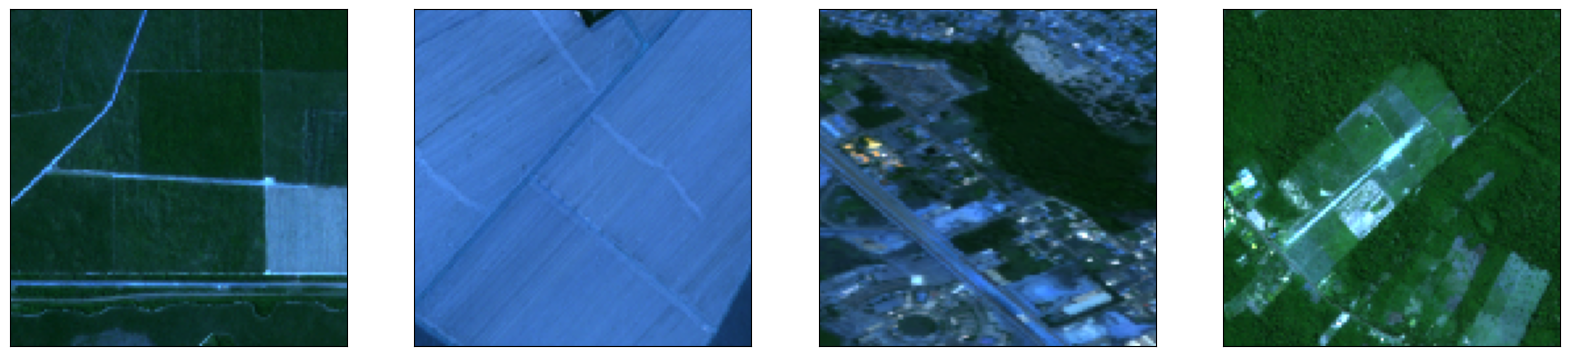

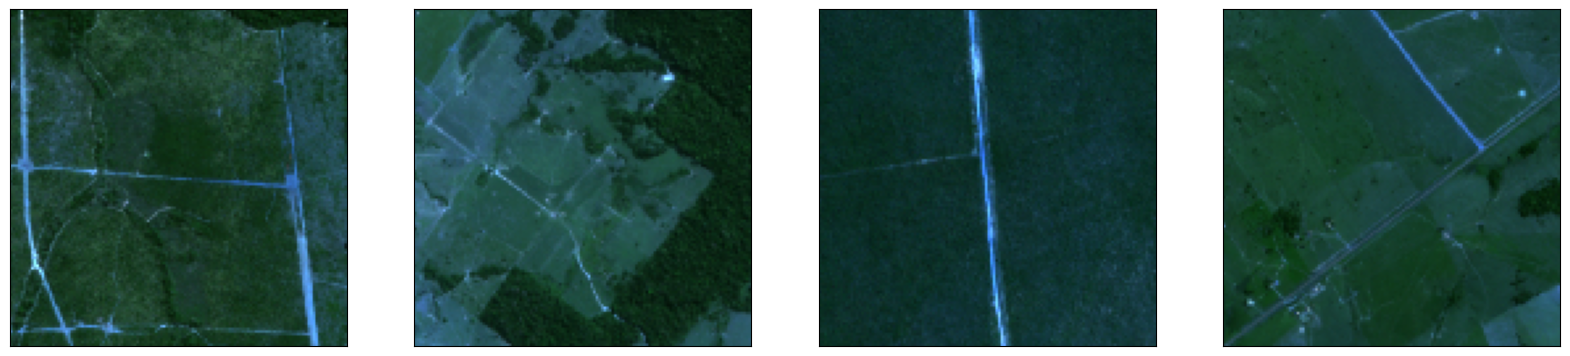

In [3]:
# Carregar imagens de treinamento
x_train = []
y_train = []

# Carregar imagens da classe "Pista" e "Não Pista" para treinamento
images, labels = load_images_from_path(train_pista_path, 1)  # 1 para "Pista"
show_images(images)
x_train += images
y_train += labels

images, labels = load_images_from_path(train_naopista_path, 0)  # 0 para "Não Pista"
show_images(images)
x_train += images
y_train += labels

### Carregar imagens de teste

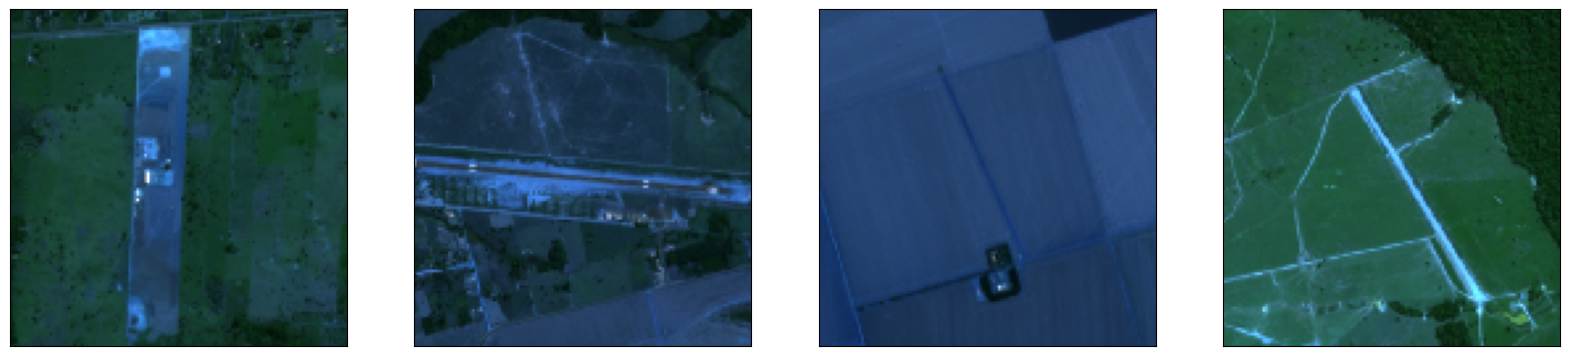

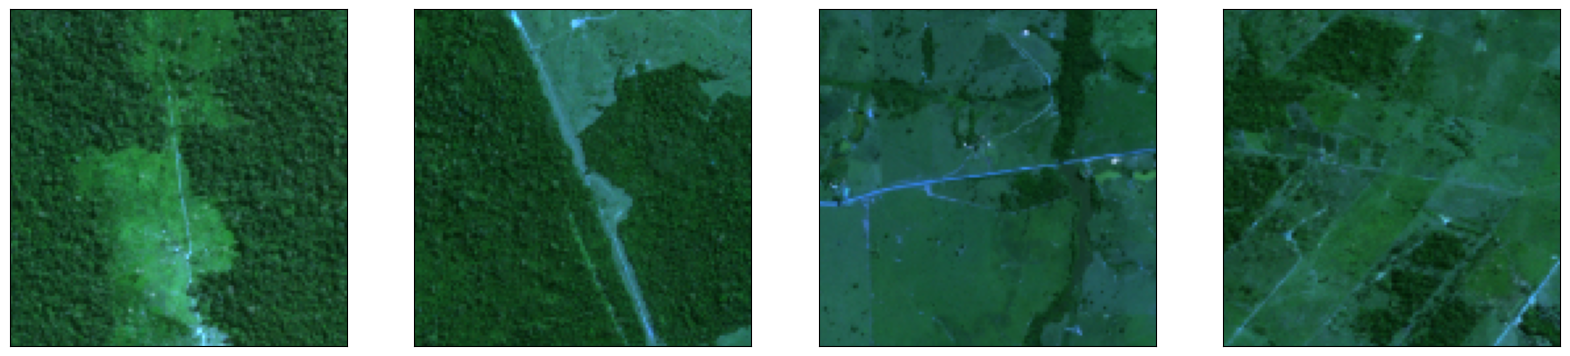

In [4]:
# Carregar imagens de teste
x_test = []
y_test = []

# Carregar imagens da classe "Pista" e "Não Pista" para teste
images, labels = load_images_from_path(test_pista_path, 1)  # 1 para "Pista"
show_images(images)
x_test += images
y_test += labels

images, labels = load_images_from_path(test_naopista_path, 0)  # 0 para "Não Pista"
show_images(images)
x_test += images
y_test += labels

### Pré-processamento dos dados

In [5]:
# Pré-processamento dos dados
x_train = np.array(x_train) / 255  # Normalização
x_test = np.array(x_test) / 255  # Normalização

# Codificação das labels (0 para "Não Pista" e 1 para "Pista")
from keras.utils import to_categorical
y_train_encoded = to_categorical(y_train)  # Codificação das labels de treinamento
y_test_encoded = to_categorical(y_test)    # Codificação das labels de teste


### Construção do modelo de Rede Neural Convolucional

In [6]:
# Construção do modelo
model = Sequential()  # Inicializa o modelo sequencial
# Primeira camada convolucional:
# - 32 filtros, cada um de tamanho 3x3
# - Função de ativação ReLU para adicionar não-linearidade
# - Define a entrada com dimensões 224x224 e 3 canais (RGB)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3))) #input_shape=(224, 224, 3)
# Primeira camada de MaxPooling:
# - Reduz a dimensionalidade espacial (resolução) pela metade
model.add(MaxPooling2D(2, 2))
# Segunda camada convolucional com 128 filtros de tamanho 3x3
model.add(Conv2D(128, (3, 3), activation='relu'))
# Segunda camada de MaxPooling
model.add(MaxPooling2D(2, 2))
# Terceira camada convolucional com 128 filtros
model.add(Conv2D(128, (3, 3), activation='relu'))
# Terceira camada de MaxPooling
model.add(MaxPooling2D(2, 2))
# Quarta camada convolucional com 128 filtros
model.add(Conv2D(128, (3, 3), activation='relu'))
# Quarta camada de MaxPooling
model.add(MaxPooling2D(2, 2))
# Camada de Flatten para transformar a saída 2D em um vetor 1D
model.add(Flatten())
# Camada densa com 256 neurônios para capturar padrões complexos
model.add(Dense(100, activation='relu'))
# Camada de saída com 2 neurônios e ativação softmax para classificação binária (Pista e Não Pista)
model.add(Dense(2, activation='softmax'))
# Compilação do modelo:
# - Otimizador Adam para o ajuste dos pesos
# - Função de perda categorical_crossentropy para problemas de classificação multiclasse
# - Acurácia como métrica de desempenho
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Exibe um resumo da arquitetura do modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             


2024-10-31 03:04:01.371965: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 100)               460900    
                                                                 
 dense_1 (

### Treinamento do modelo

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Limpa a sessão atual para liberar memória
K.clear_session()

# Definindo o batch size
batch_size = 32

# Configuração do EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitora a perda na validação
    patience=50,          # Número de épocas sem melhora antes de parar
    restore_best_weights=True  # Restaura os pesos da melhor época
)

# Treinamento do modelo com o callback EarlyStopping
hist = model.fit(
    x_train, y_train_encoded,
    epochs=1000,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping]  # Adiciona o callback aqui
)

# Gerar o timestamp para o nome do modelo salvo
prefix = 'Model'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Define o nome do arquivo com o prefixo, timestamp e extensão .h5
filename = f"{prefix}_{timestamp}.h5"
# Caminho completo onde o modelo será salvo
model_saved = f"./{filename}"
# Salva o modelo
model.save(model_saved)
print(f"Modelo salvo como: {model_saved}")

Epoch 1/1000
40/40 [==============================] - 35s 834ms/step - loss: 0.6663 - accuracy: 0.6281 - val_loss: 0.9850 - val_accuracy: 0.5219
Epoch 2/1000
40/40 [==============================] - 44s 1s/step - loss: 0.6828 - accuracy: 0.5523 - val_loss: 0.6704 - val_accuracy: 0.4906
Epoch 3/1000
40/40 [==============================] - 41s 1s/step - loss: 0.6359 - accuracy: 0.6484 - val_loss: 0.7208 - val_accuracy: 0.6062
Epoch 4/1000
40/40 [==============================] - 42s 1s/step - loss: 0.6077 - accuracy: 0.6930 - val_loss: 0.6139 - val_accuracy: 0.7437
Epoch 5/1000
40/40 [==============================] - 41s 1s/step - loss: 0.5954 - accuracy: 0.6930 - val_loss: 0.5193 - val_accuracy: 0.7437
Epoch 6/1000
40/40 [==============================] - 47s 1s/step - loss: 0.5983 - accuracy: 0.6836 - val_loss: 0.2362 - val_accuracy: 0.9312
Epoch 7/1000
40/40 [==============================] - 46s 1s/step - loss: 0.5840 - accuracy: 0.6945 - val_loss: 0.6560 - val_accuracy: 0.6594
Epo

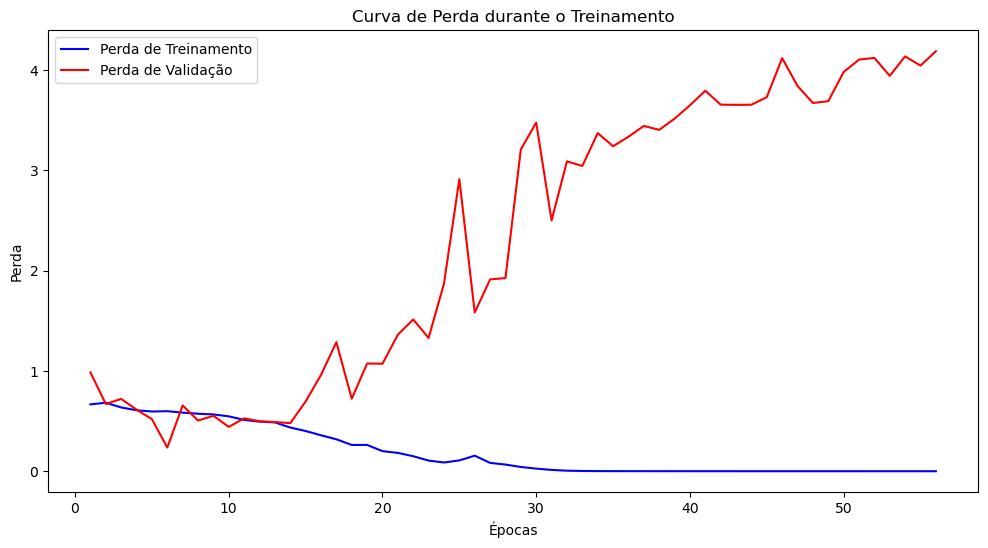

In [8]:
# Plotar as curvas de precisão e perda
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotar a curva de perda
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'b-', label='Perda de Treinamento')
plt.plot(epochs, val_loss, 'r-', label='Perda de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.title('Curva de Perda durante o Treinamento')
plt.legend()
plt.show()

48/48 [==============================] - 13s 279ms/step


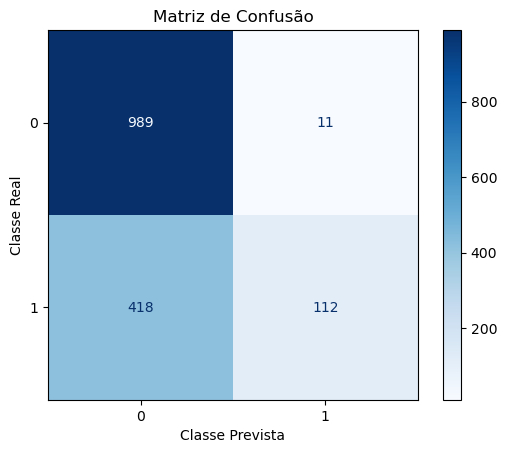

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Realiza previsões no conjunto de teste
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converte as previsões para classes (índices das categorias)
y_true_classes = np.argmax(y_test_encoded, axis=1)  # Converte os valores reais para classes

# Gera a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
ConfusionMatrixDisplay(conf_matrix).plot(cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.show()


### Testes adicionais com imagens não analisadas

In [10]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image  # Importação correta
from tensorflow.keras.models import load_model  # Importação correta

# Função para carregar novas imagens
def load_new_images(path, num_images=5):
    all_images = []
    # Percorre todos os arquivos no diretório
    for file in os.listdir(path):
        img = image.load_img(os.path.join(path, file), target_size=(128, 128))  # Alinhe o tamanho ao do modelo
        all_images.append(image.img_to_array(img) / 255)  # Normalização dos pixels
    
    # Seleciona aleatoriamente as imagens
    random_images = random.sample(all_images, min(num_images, len(all_images)))
    
    print(f'Total de imagens carregadas: {len(all_images)}')
    print(f'Número de imagens selecionadas: {len(random_images)}')
    
    return np.array(random_images)

# Carregar o modelo treinado
model_path = './Model.h5'  # Substitua pelo caminho correto do seu modelo
model = load_model(model_path)

# Carregar novas imagens para teste
new_data_path = './Todas/Totas0/'  # Caminho para as novas imagens
x_new = load_new_images(new_data_path)

Total de imagens carregadas: 1840
Número de imagens selecionadas: 5


1/1 [==============================] - 0s 89ms/step


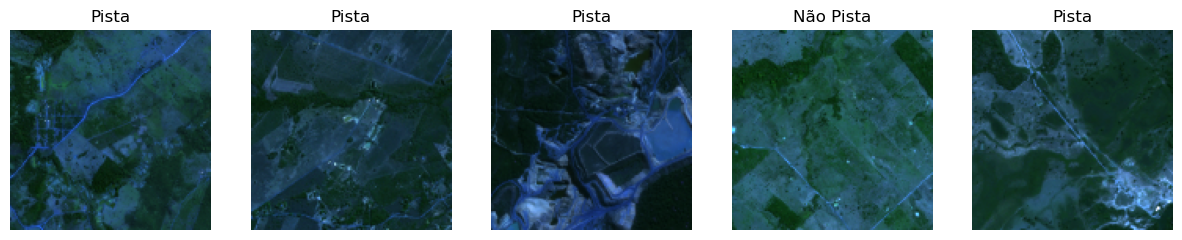

In [11]:


# Realizar previsões
predictions = model.predict(x_new)

# Interpretar as previsões
predicted_classes = np.argmax(predictions, axis=1)
class_labels = ['Não Pista', 'Pista']  # Substitua pelos rótulos correspondentes

# Função para exibir imagens e suas previsões
def show_predictions(images, predicted_classes):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[predicted_classes[i]])
        plt.axis('off')
    plt.show()

# Exibir as previsões
show_predictions(x_new, predicted_classes)
